# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)
sales = sales.sort_values(['sqft_living','price'])
sales

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
19452,3980300371,20140926T000000,142000.0,0.0,0.00,290.0,20875,1.0,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620.0,22850.0
15381,2856101479,20140701T000000,276000.0,1.0,0.75,370.0,1801,1.0,0,0,...,5,370,0,1923,0,98117,47.6778,-122.389,1340.0,5000.0
860,1723049033,20140620T000000,245000.0,1.0,0.75,380.0,15000,1.0,0,0,...,5,380,0,1963,0,98168,47.4810,-122.323,1170.0,15000.0
18379,1222029077,20141029T000000,265000.0,0.0,0.75,384.0,213444,1.0,0,0,...,4,384,0,2003,0,98070,47.4177,-122.491,1920.0,224341.0
4868,6896300380,20141002T000000,228000.0,0.0,1.00,390.0,5900,1.0,0,0,...,4,390,0,1953,0,98118,47.5260,-122.261,2170.0,6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8092,1924059029,20140617T000000,4668000.0,5.0,6.75,9640.0,13068,1.0,1,4,...,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270.0,10454.0
9254,9208900037,20140919T000000,6885000.0,6.0,7.75,9890.0,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540.0,42730.0
3914,9808700762,20140611T000000,7062500.0,5.0,4.50,10040.0,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930.0,25449.0
7252,6762700020,20141013T000000,7700000.0,6.0,8.00,12050.0,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940.0,8800.0


# Import useful functions from previous notebook

In [3]:
def get_numpy_data(data_frame, features, output):
    data_frame['constant'] = 1 # this is how you add a constant column to data frame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):

    # the following line will convert the features and output into a numpy matrix:
    features_df = data_frame[features]
    feature_matrix = features_df.to_numpy()
   
    output_df = data_frame[output]
    output_array = output_df.to_numpy()

    return(feature_matrix, output_array)

In [4]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') # the [] around 'sqft_living' makes it a list
print(example_features[0,:]) # this accesses the first row of the data the ':' indicates 'all columns'
print(example_output[0]) # and the corresponding output

[  1. 290.]
142000.0


In [5]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)

    return (predictions)

In [6]:
my_weights = np.array([1., 1.]) # the example weights
test_predictions = predict_output(example_features, my_weights)
print(test_predictions[0])
print(test_predictions[1])

291.0
371.0


# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [7]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    
    if (feature_is_constant):
        derivative = np.dot(2,np.dot(errors, feature))
    else:
        derivative = np.dot(2,np.dot(errors, feature)) + np.dot(2,np.dot(l2_penalty, weight))
    
    return derivative

In [8]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print(feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print(np.sum(errors*example_features[:,1])*2+20.)

# next two lines should print the same values
print(feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print(np.sum(errors)*2.)

-56554166815950.0
-56554166815950.0
-22446749330.0
-22446749330.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [9]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print('Starting gradient descent with l2_penalty = ' + str(l2_penalty))
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration < max_iterations:
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)

        # compute the errors as predictions - output
        errors = np.subtract(predictions, output)

        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print('Cost function = ' + str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2)))
        
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)                

            # subtract the step size times the derivative from the current weight
            if (i == 0):
                feature_is_constant = True
                derivative = feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, feature_is_constant)
                weights[i] = weights[i] - (step_size*derivative)
            else:
                feature_is_constant = False
                derivative = feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, feature_is_constant)
                weights[i] = weights[i] - (step_size*derivative)
            
    print('Done with gradient descent at iteration: ' + str(iteration))
    print('Learned weights = ' + str(weights))
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [10]:
simple_features = ['sqft_living']
my_output = 'price'

In [11]:
(simple_feature_matrix, output) = get_numpy_data(sales, simple_features, my_output)

In [12]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.1` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights`

In [13]:
l2_penalty = 0.1

In [14]:
simple_weights = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=max_iterations)

Starting gradient descent with l2_penalty = 0.1
Iteration = 1
Cost function = 9217325138472070.0
Iteration = 2
Cost function = 6147345564844980.0
Iteration = 3
Cost function = 4296084086077826.5
Iteration = 4
Cost function = 3179734944131010.0
Iteration = 5
Cost function = 2506553213161872.0
Iteration = 6
Cost function = 2100610640270264.8
Iteration = 7
Cost function = 1855818833073353.2
Iteration = 8
Cost function = 1708204286390232.0
Iteration = 9
Cost function = 1619189647192850.0
Iteration = 10
Cost function = 1565511969947073.8
Iteration = 20
Cost function = 1484492732774825.5
Iteration = 30
Cost function = 1483977608843702.5
Iteration = 40
Cost function = 1483974332729873.2
Iteration = 50
Cost function = 1483974310961413.0
Iteration = 60
Cost function = 1483974309884188.5
Iteration = 70
Cost function = 1483974308938519.5
Iteration = 80
Cost function = 1483974307993687.0
Iteration = 90
Cost function = 1483974307048860.0
Iteration = 100
Cost function = 1483974306104033.5
Iteration 

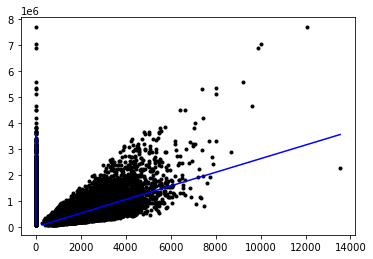

In [17]:
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights),'b-')